In [1]:
!nvidia-smi

Thu Dec 26 08:20:19 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   46C    P8              9W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [1]:
import torch
import torchvision
from torchvision import transforms, datasets, models
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
import pandas as pd
from glob import glob
from torch.utils.data import DataLoader
import copy

In [2]:
data_dir = "../input/chest-xray-pneumonia/chest_xray/chest_xray"

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
EPOCHS = 30
TEST = 'test'
TRAIN = 'train'

In [5]:
VAL = 'val'

In [19]:
'''
CREATE VALIDATION FOLDER OUT OF TRAIN FOLDER
import os
import shutil
import random

#Paths
train_dir = TRAIN
validation_dir = 'validation'

#subfolders
classes =['NORMAL','PNEUMONIA']

#Creating validation folder structure
for cls in classes:
  os.makedirs(os.path.join(validation_dir,cls),exist_ok=True)

#Split data
validation_split =0.1

for cls in classes:
  source_fol = os.path.join(train_dir,cls)
  dest_fol = os.path.join(validation_dir,cls)

  #Getting all files in source folder
  all_files = os.listdir(source_fol)
  val_count = int(len(all_files)*validation_split)
  val_files = all_files[:val_count]

  #Moving the random 20% files from val_files to validation folder/cls
  for val_file in val_files:
    src_file = os.path.join(source_fol,val_file)
    dest_file = os.path.join(dest_fol,val_file)

    shutil.move(src_file,dest_file)
    print(f'Moved {src_file} to {dest_file}') 

'''

"\nCREATE VALIDATION FOLDER OUT OF TRAIN FOLDER\nimport os\nimport shutil\nimport random\n\n#Paths\ntrain_dir = TRAIN\nvalidation_dir = 'validation'\n\n#subfolders\nclasses =['NORMAL','PNEUMONIA']\n\n#Creating validation folder structure\nfor cls in classes:\n  os.makedirs(os.path.join(validation_dir,cls),exist_ok=True)\n\n#Split data\nvalidation_split =0.1\n\nfor cls in classes:\n  source_fol = os.path.join(train_dir,cls)\n  dest_fol = os.path.join(validation_dir,cls)\n\n  #Getting all files in source folder\n  all_files = os.listdir(source_fol)\n  val_count = int(len(all_files)*validation_split)\n  val_files = all_files[:val_count]\n\n  #Moving the random 20% files from val_files to validation folder/cls\n  for val_file in val_files:\n    src_file = os.path.join(source_fol,val_file)\n    dest_file = os.path.join(dest_fol,val_file)\n\n    shutil.move(src_file,dest_file)\n    print(f'Moved {src_file} to {dest_file}') \n\n"

In [6]:
# DATA PREPROCESSING

def data_transform(phase):
  if phase == TRAIN:
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ])

  if phase == TEST:
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ])

  if phase == VAL:
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ])
  return transform

In [7]:
# Applying data transformation on all images of all folders and defining DATALOADERS
import os
image_datasets = {x:datasets.ImageFolder(os.path.join(data_dir,x), data_transform(x)) for x in [TRAIN,TEST,VAL]}

dataloaders ={TRAIN: DataLoader(image_datasets[TRAIN],batch_size=4,shuffle=True ),
              TEST: DataLoader(image_datasets[TEST],batch_size=1,shuffle=True ),
              VAL: DataLoader(image_datasets[VAL],batch_size=1,shuffle=True )}

In [9]:
dataset_sizes = {x: len(image_datasets[x]) for x in [TRAIN,VAL]}
print(dataset_sizes)

classes = image_datasets[TRAIN].classes
class_names = image_datasets[TRAIN].classes
print(class_names)

{'train': 5216, 'val': 16}
['NORMAL', 'PNEUMONIA']


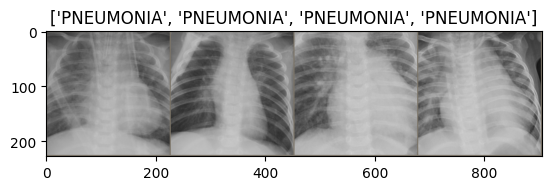

In [10]:
# VISUALIZE THE CHEST X-RAYS

def ImShow(inp,title=None):
  inp = inp.numpy().transpose((1,2,0))
  mean = np.array([0.485,0.456,0.406])
  std = np.array([0.229,0.224,0.225])
  inp = std*inp+mean
  inp = np.clip(inp,0,1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.pause(0.001)


inputs, classes = next(iter(dataloaders[TRAIN]))   # takes 1 batch at a time from dataloaders[TRAIN]
out = torchvision.utils.make_grid(inputs)
ImShow(out,title=[class_names[x] for x in classes])

In [11]:
#Loading Model VGG16

model_ft = models.vgg16()

In [12]:
# Freezing the Feature extraction layer

for param in model_ft.features.parameters():
  param.requires_grad = False

num_classes = len(class_names)
model_ft.classifier[6] = nn.Linear(4096,num_classes)
model_ft = model_ft.to(device)

In [13]:
#Hyperparameters

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_ft.parameters(),lr = 0.001, momentum=0.9, weight_decay = 0.01)
#Decaying LR by 0.1 after every 10 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size =5,gamma=0.1)

In [14]:
# Train model
def train_model(model, loss_fn, optimizer, scheduler, num_epochs):
    best_model_wts = copy.deepcopy(model.state_dict())  # Save initial weights
    best_acc = 0.0
    model = model.to(device)  # Move model to the correct device

    for epoch in range(num_epochs):
        print("Epoch: {}/{}".format(epoch + 1, num_epochs))
        print("=" * 50)

        # Loop through phases
        for phase in [TRAIN, VAL]:
            if phase == TRAIN:
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluation mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for data in dataloaders[phase]:
                inputs, labels = data
                inputs = inputs.to(device)  # Move inputs to device
                labels = labels.to(device)  # Move labels to device

                optimizer.zero_grad()  # Clear gradients

                # Enable or disable gradient computation based on phase
                with torch.set_grad_enabled(phase == TRAIN):
                    outputs = model(inputs)  # Forward pass
                    _, preds = torch.max(outputs, 1)  # Get predictions
                    loss = loss_fn(outputs, labels)  # Compute loss

                    if phase == TRAIN:
                        loss.backward()  # Backward pass
                        optimizer.step()  # Update weights

                # Update running metrics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # Calculate loss and accuracy for the epoch
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print("{} Loss: {:.4f} Accuracy: {:.4f}".format(phase, epoch_loss, epoch_acc))

            # Deep copy the model if it has better accuracy on validation
            if phase == VAL and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        # Step the learning rate scheduler only after the training phase
        scheduler.step()

    print("Best Val Accuracy: {:.4f}".format(best_acc))
    
    # Load the best model weights
    model.load_state_dict(best_model_wts)
    return model


In [15]:
model_ft = train_model(model_ft,loss_fn,optimizer,exp_lr_scheduler,EPOCHS)

Epoch: 1/30
train Loss: 0.4241 Accuracy: 0.8169
val Loss: 0.5175 Accuracy: 0.6875
Epoch: 2/30
train Loss: 0.2343 Accuracy: 0.9061
val Loss: 0.7451 Accuracy: 0.6250
Epoch: 3/30
train Loss: 0.1921 Accuracy: 0.9231
val Loss: 0.9323 Accuracy: 0.5625
Epoch: 4/30
train Loss: 0.1685 Accuracy: 0.9337
val Loss: 0.4825 Accuracy: 0.7500
Epoch: 5/30
train Loss: 0.1744 Accuracy: 0.9331
val Loss: 0.7163 Accuracy: 0.5625
Epoch: 6/30
train Loss: 0.1297 Accuracy: 0.9525
val Loss: 0.8935 Accuracy: 0.5625
Epoch: 7/30
train Loss: 0.1155 Accuracy: 0.9574
val Loss: 0.7437 Accuracy: 0.6250
Epoch: 8/30
train Loss: 0.1076 Accuracy: 0.9603
val Loss: 0.6995 Accuracy: 0.6250
Epoch: 9/30
train Loss: 0.1067 Accuracy: 0.9601
val Loss: 0.8875 Accuracy: 0.6250
Epoch: 10/30
train Loss: 0.1047 Accuracy: 0.9617
val Loss: 0.7809 Accuracy: 0.6250
Epoch: 11/30
train Loss: 0.1010 Accuracy: 0.9613
val Loss: 0.7503 Accuracy: 0.6250
Epoch: 12/30
train Loss: 0.1007 Accuracy: 0.9622
val Loss: 0.7462 Accuracy: 0.6250
Epoch: 13/30


In [17]:
# TEST function

def test_model(model):
    correct = 0.0
    total = 0.0
    true_labels=[]
    pred_labels=[]
    with torch.no_grad():
        for data in dataloaders[TEST]:
            inputs,labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _,preds = torch.max(outputs,1)
            true_labels.append(labels.item())
            pred_labels.append(preds.item())
            total += labels.size(0)
            correct += torch.sum(preds == labels.data)
        acc = correct/total

    print("The correct predictions are: {} out of total images: {}. \n The Accuracy is: {}".format(correct,total,acc))
            

In [18]:
# TESTING MODEL

test_model(model_ft)

The correct predictions are: 501.0 out of total images: 624.0. 
 The Accuracy is: 0.8028846383094788
